In [ ]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
from scipy import stats
import seaborn as sns
from scipy.stats import shapiro

# Read Data from csv
data = pd.read_csv("faceit_match_data.csv", index_col=0)

def translate_strings_to_ints(data):
    """
    Translates strings in the input list to integers and returns a new list with the translated data.
    
    Parameters:
    data (list): The input list containing strings, integers, or floats.
    
    Returns:
    list: A new list with strings translated to integers.
    dict: A dictionary mapping the original strings to their corresponding integer values.
    """
    translated_data = []
    string_to_int = {}
    current_int = 1
    
    for item in data:
        if isinstance(item, str):
            if item not in string_to_int:
                string_to_int[item] = current_int
                current_int += 1
            translated_data.append(string_to_int[item])
        else:
            translated_data.append(item)
    
    return translated_data


# mache vorhersage aufgrund der daten
# eingabe: karte
# errechne gewinnwahrscheinlichkeit für die karte: wins auf Karte / (alle matches auf karte)
# vorhersage kills auf der karte
# bishreige kills, lineare regression und dann vorhersage?
# vorhersage Tode auf der karte
# ...

print(data.columns)
#print(data)

def getWinProbabilityOfMap(data:pd, map):
    mapData = data.loc[(data['Map'] == map)]
    wins = mapData.loc[(data['Result'] == 1)]
    loses = mapData.loc[(data['Result'] == 0)]
    winRate = len(wins) / (len(wins) + len(loses))
    return winRate

'''
    Lineare Regression: (Ausgleichsgerade für Datenpunkte die nicht auf einer gerade liegen)
        - Least squares:
            a_star = 𝜎_𝑥𝑦/𝜎²_𝑥
            b_star = y_mean - aStern *x_mean

            x = np.array([np.min(X) - 1, np.max(X) + 1]) 
            y = a_star * x + b_star
            plt.plot(x, y)  # Gerade plotten
'''

def median(x):
    i = len(x)/2
    if np.isclose(i, round(i)):#i gerade
        i = round(i)
        return x[i]
    else:# i ungerade
        i = int(i)
        return (x[i] + x[i+1])/2

def quantile(x,p):
    n = len(x)
    i = n*p
    if np.isclose(i, round(i)):#gerade
        i = round(i)
        return x[i] 
    else:#ungerade
        i = int(i)
        return (x[i] + x[i+1])/2

def covariance(x,y):
    x_mean = sum(x)/len(x)
    y_mean = sum(y)/len(y)
    return sum([(x[i] - x_mean)*(y[i] - y_mean) for i in range(len(x))]) / len(x)

def variance(X):
    x_mean = sum(X)/len(X)
    return sum([(x - x_mean)**2 for x in X]) / len(X)

def standardDeviation(x):
    return math.sqrt(variance(x))

def least_squares(x,y):
    a_star = covariance(x,y)/variance(x)
    x_mean = sum(x) /len(x)
    y_mean = sum(y) /len(y)
    b_star = y_mean - a_star * x_mean 
    return a_star, b_star

def correlation(x,y):
    return covariance(x,y) / (standardDeviation(x) * standardDeviation(y))

def plotFeature(feature:str):
    #Kill Statistik
    kills = translate_strings_to_ints(data[feature])
    plt.plot(kills, label=feature)
    plt.plot(np.linspace(min(kills), min(kills), 100), label="Minimum")
    plt.plot(np.linspace(max(kills), max(kills), 100), label="Maximun")
    plt.plot(np.linspace(np.mean(kills), np.mean(kills), 100), label="Mittelwert")
    plt.plot(np.linspace(median(kills), median(kills), 100), label="Median")
    plt.plot([], [], ' ', label= "Standardabweichung: " +str(standardDeviation(kills)))
    plt.plot([], [], ' ', label= "Varianz: " + str(str(variance(kills))))
    plt.grid()
    plt.legend()
    plt.xlabel("Match")
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

def plot2Features(featureA,featureB):
    # Kills/Deaths scatter plot 
    kd = data[[featureA,featureB]]
    kills = translate_strings_to_ints(kd[featureA])
    deaths = translate_strings_to_ints(kd[featureB])

    plt.scatter(kills,deaths)
    a_star, b_star = least_squares(np.array(kills),np.array(deaths))
    x = np.array([np.min(kills) - 1, np.max(kills) + 1]) 
    y = a_star * x + b_star
    plt.plot(x, y)  # Gerade plotten
    plt.xlabel(featureA)
    plt.ylabel(featureB)
    # Wenn Korrelation = 0 keine (lineare) Abhängigkeit zwischen den daten
    plt.plot([], [], ' ', label= "Korrelation:" + str(correlation(np.array(kills),np.array(deaths))))
    plt.title(featureA +"/"+ featureB)
    plt.legend()
    plt.grid()
    plt.show()

def analyze2Features(featureA,featureB):
    plotFeature(featureA)
    plotFeature(featureB)
    plot2Features(featureA, featureB)
    
    
def analyzeDistribution(feature):
    featureData = translate_strings_to_ints(data[feature])
    plt.ylabel("Anzahl Matches mit der Anzahl an "+feature)
    plt.xlabel("Anzahl "+feature)
    plt.hist(featureData, bins = len(featureData))
    plt.xticks = featureData
    plt.title("Verteilung der " +feature)
    plt.grid()
    plt.show()
    #H0: Feature ist X² (stetig) gleich verteilt (X²-Anpassungstest)
    #
    #Binomialverteilung (#Normalverteilung (simuliert mit binominialverteilung))
    # 1 match = Zufallsexperment mit 24 Runden in denen ich 1 - 5 Kills machen kann
    # Runden = n = 24
    # kill wahrscheinlichkeit = p = (sum(kills)/len(kills))/24    mittelwert/24-Runden
    n = 24
    p = (sum(featureData)/len(featureData))/n
    
    x = np.arange(0, n + 1)   # Mögliche Werte von 0 bis n
    y = stats.binom.cdf(x, n, p)    # Wahrscheinlichkeit (PMF)

    # Plot erstellen
    #plt.plot(x, y, color='red', alpha=0.7, label=f"Binomial(n={n}, p={p})")    

    #Rote Linie als Beispiel Normalverteilung zum vergleich auf die Daten Plotten:
    mu = sum(featureData)/len(featureData)
    sigma = standardDeviation(featureData)

    x = np.linspace(0, max(featureData), 1000)  # 1000 Werte zwischen 0 und max(data)
    y = stats.norm.pdf(x, mu, sigma)*100    # Wahrscheinlichkeitsdichtefunktion (PDF) * 100???
    # Plot
    plt.plot(x, y, color='red', linestyle='-', linewidth=2, label=f"Mittelwert: N(μ={mu})")
    plt.plot([], [], ' ', label=f"Standardanweichung: σ={sigma})")
    plt.hist(featureData, bins = len(featureData), color="blue")
    plt.axvline(mu, color='black', linestyle='--', label=f"Mittelwert (μ={mu})")  # Mittellinie
    plt.legend()
    plt.grid()
    plt.title("(Normal-)Verteilung der "+ feature)
    plt.show()

    #Q-Plot für verteilung norm, wenn datenpunkte auf der roten linie sind, ist es eine normalverteilung
    stats.probplot(featureData, dist="norm", plot=plt)
    plt.title("Q-Q-Plot der " + feature + " (Punkte auf der linie = normalverteilt)")
    plt.grid()
    plt.show()


Index(['Created At', 'Result', 'Map', 'Kills', 'Assists', 'Deaths',
       'Headshots', 'Double Kills', 'Triple Kills', 'Quadro Kills',
       'Penta Kills', 'K/D Ratio', 'ADR', 'K/R Ratio', 'Player Id'],
      dtype='object')


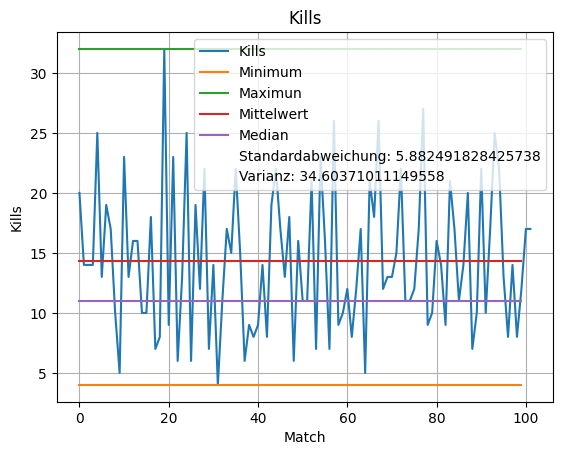

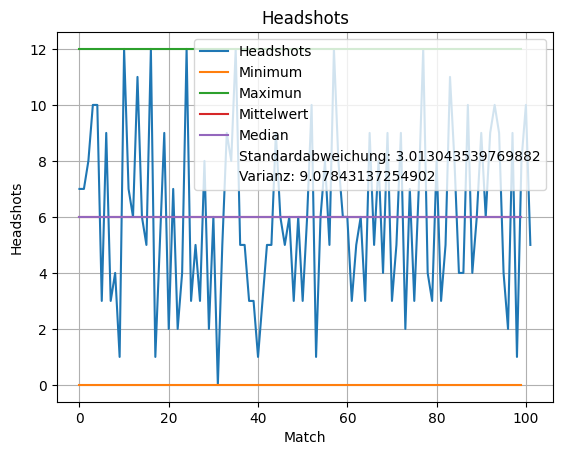

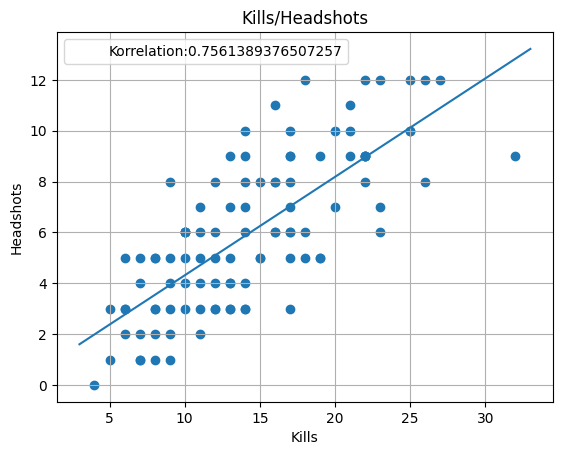

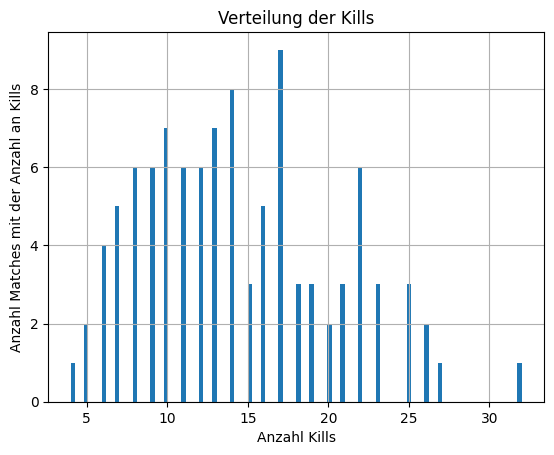

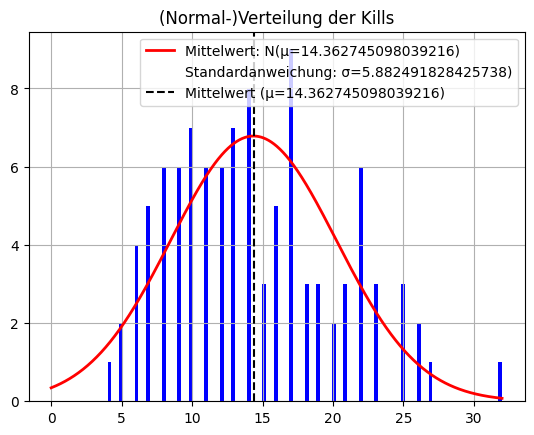

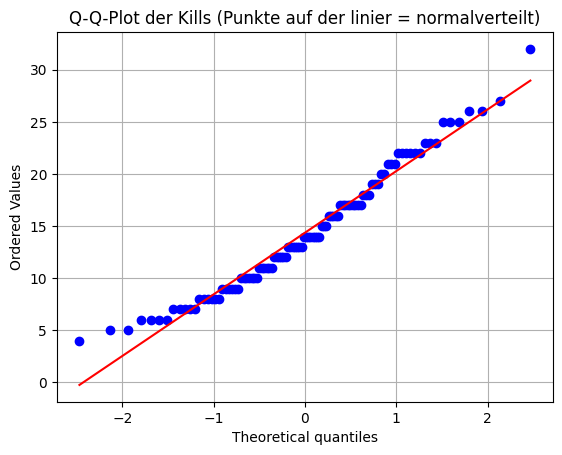

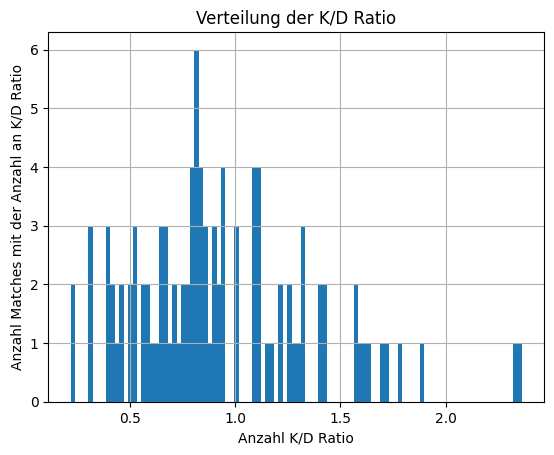

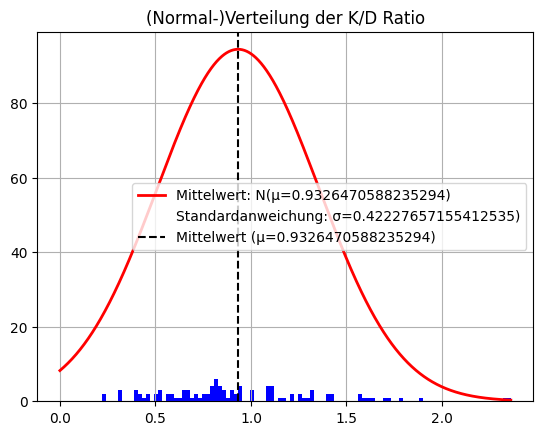

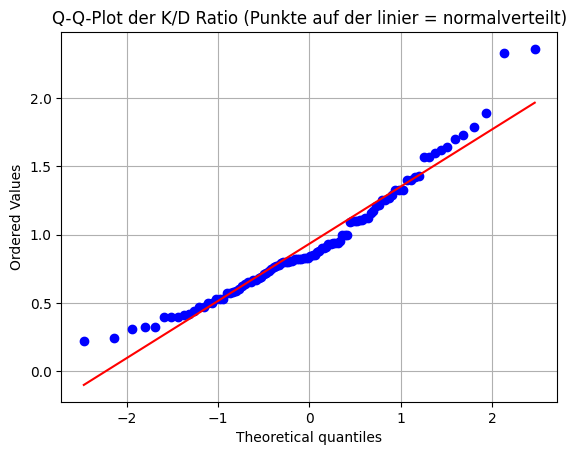

0.675


In [63]:
"""

"""
analyze2Features("Kills","Headshots")
#analyze2Features("Kills","Created At")
analyzeDistribution("Kills")
analyzeDistribution("K/D Ratio")

print(stats.bernoulli(getWinProbabilityOfMap(data, "de_dust2")).pmf(1))
#wins = data[data['Result'] == 1]

#sns.pairplot(data); plt.show()



Index(['Player ID', 'Player Name', 'Created At', 'Map', 'Kills', 'Deaths',
       'Assists', 'Result', 'Headshots', 'Headshots %', 'Damage', 'MVPs',
       'Double Kills', 'Triple Kills', 'Quadro Kills', 'Penta Kills',
       'Clutch Kills', 'Pistol Kills', 'Zeus Kills', 'Knife Kills',
       'Sniper Kills', 'Sniper Kill Rate per Match',
       'Sniper Kill Rate per Round', 'K/D Ratio', 'K/R Ratio', 'ADR',
       '1v1Count', '1v1Wins', 'Match 1v1 Win Rate', '1v2Count', '1v2Wins',
       'Match 1v2 Win Rate', 'First Kills', 'Entry Count', 'Entry Wins',
       'Match Entry Rate', 'Match Entry Success Rate', 'Utility Count',
       'Utility Damage', 'Utility Enemies',
       'Utility Damage Success Rate per Match',
       'Utility Success Rate per Match', 'Utility Usage per Round',
       'Utility Damage per Round in a Match', 'Utility Successes',
       'Flash Count', 'Enemies Flashed', 'Flash Successes',
       'Enemies Flashed per Round in a Match', 'Flashes per Round in a Match',
    

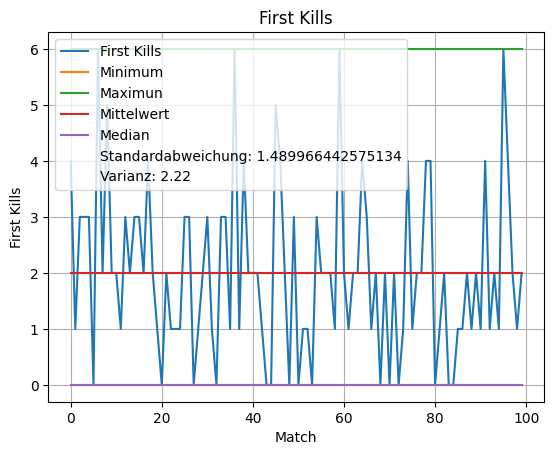

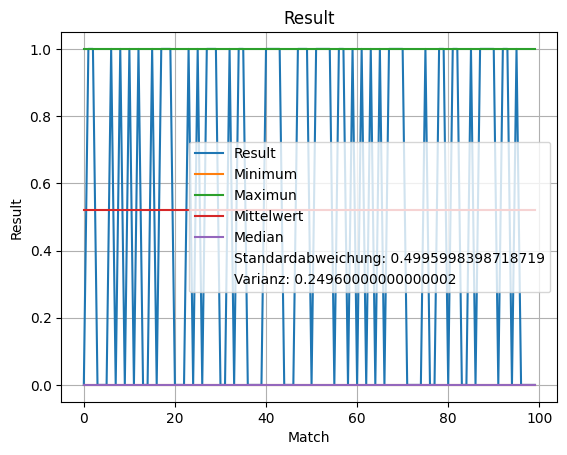

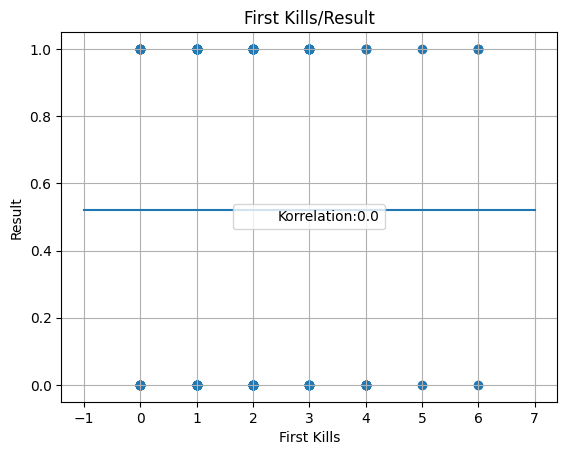

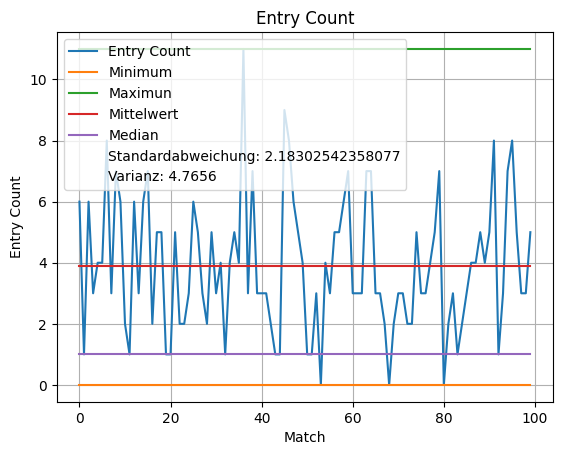

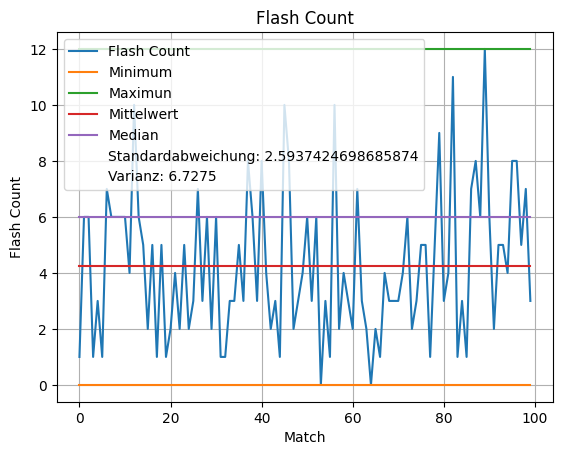

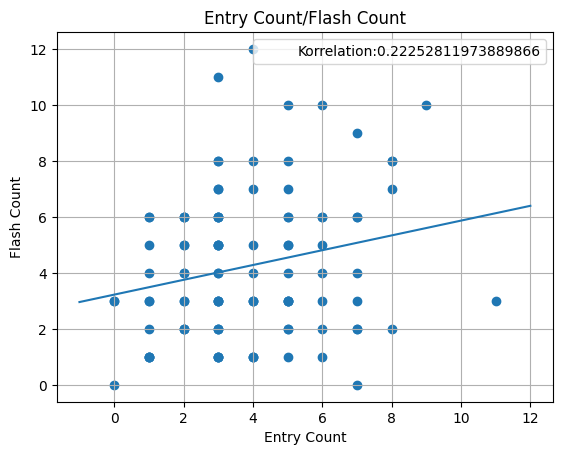

In [67]:

matchDetails = pd.read_csv("faceit_match_details.csv", index_col=0)

#Override data with matchDetails data
data = matchDetails

print(matchDetails.columns)

#analyze2Features("Utility Count","Utility Damage")
analyze2Features("First Kills","Result")
analyze2Features("Entry Count", "Flash Count")